# Running experiments
In the following blocks, you can uncomment the code to run the experiments. The code is commented out to avoid running it by accident.

There are 3 types of experiments:
1. Training a new model and testing its performance. The created model and output data will be saved to be reused or analysed below.
2. Training and testing new models using 10-fold cross-validation. The output data will be saved to be reused or analysed below.
3. Loading a pretrained model and testing its performance. The output data will be saved to be reused or analysed below.

In the cell below, you can find the parameters for the experiments. The parameters are the same for all experiments. The only difference is the function that is called.

## Parameters


In [1]:
# TRAINING PARAMETERS
EARLY_STOPPING = True # use early stopping
PATIENCE = 3 # number of epochs to wait for improvement before early stopping
LEARNING_RATE = 2e-5 # learning rate for the optimizer
BATCH_SIZE = 8 # batch size for training

# ARCHITECTURE & CONTEXT PARAMETERS
MAX_LENGTH = 512 # maximum length of the input sequence, by default, sequences are padded or truncated to this length
SKIP_OVERFLOWING_OBSERVATIONS = True  # skip observations that exceed the max length instead of truncating them
INCLUDE_POS = True  # include POS tags in the input data for more context
INCLUDE_QUERY = True  # include the query in the input for more context

# DATA PARAMETERS
INPUT_DATA_PATH = '../data/preprocessed/val_preprocessed.json'  # location of the preprocessed data to train and test on
OUTPUT_DATA_PATH = '../data/output/val_predictions_mbert_POSSKIP.csv'  # location to save the predictions of the model
MODEL_PATH = "./mbert_token_classifier_POSSKIP/"  # path for saving new model (experiments 1. and 2.) or loading pretrained model (experiment 3.)

DEBUG = False  # print extra information during runtime (not recommended for large datasets)


In [2]:
# DO NOT CHANGE THE CODE IN THIS CELL!!
import NN_utils
from NN_utils import NN_Args
args = NN_Args()
args.MAX_LENGTH = MAX_LENGTH
args.patience = PATIENCE
args.include_POS = INCLUDE_POS
args.include_query = INCLUDE_QUERY
args.skip_overflowing_observation = SKIP_OVERFLOWING_OBSERVATIONS
args.data_path = INPUT_DATA_PATH
args.output_path = OUTPUT_DATA_PATH
args.model_path = MODEL_PATH
args.DEBUG = DEBUG

## Experiment 1: Train and test a new model
Depending on the size of the dataset, this experiment can take a long time to run. The model will be saved to the path specified in the parameters above. The output data will be saved to the path specified in the parameters above.

In [9]:
import NN_Classifier
# UNCOMMENT THIS LINE TO RUN THE EXPERIMENT
#NN_Classifier.train_and_test_model(args) # train a new model and test it once

## Experiment 2: Train and test a new model using cross-validation
This experiment will train and test a new model using 10-fold cross-validation. The output data will be saved to the path specified in the parameters above. Without a GPU, this experiment can take a VERY long time to run.

In [4]:
import NN_Classifier
# UNCOMMENT THIS LINE TO RUN THE EXPERIMENT
# NN_Classifier.train_and_test_cross_validation(args) # train and test a new model using cross-validation

## Experiment 3: Load a pretrained model and test it
This experiment will load a pretrained model and test it on the evaluation data. The output data will be saved to the path specified in the parameters above. The runtime of this experiment is relatively short, even without a GPU.

In [8]:
import NN_Classifier
# UNCOMMENT THIS LINE TO RUN THE EXPERIMENT
NN_Classifier.load_and_test_model(args) # load a pretrained model and test it

Data prepared, there are 499 observations in the data.
Lengths of data: 499 499
Maximum length of features or labels: 1573

get_data_for_NN executed in 0.1918 seconds
Length of JSON data: 499
Loading tokenizer and model...
Tokenizer loaded!
Dataset and dataloader created!
Model loaded!

Performing inference
Evaluation Metrics:
Accuracy: 0.6155
Accuracy_flat: 0.5821
Precision: 0.3028
Precision_flat: 0.4341
Recall: 0.2024
Recall_flat: 0.2384
F1: 0.1897
F1_flat: 0.3078


# Qualitative analysis

In [10]:
# IMPORTS & PREP STUFF. DONT CHANGE
import pandas as pd
from NN_utils import get_data_for_NN, set_seed

!pip install langdetect
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

set_seed(42)



  Using cached langdetect-1.0.9-py3-none-any.whl


## Label length weirdness
While comparing actual and predicted labels, we came across the weird problem, that the labels did not match the original text inputs anymore. To be exact, the labels were suddenly more numerous than the tokens we had them for. Here is the reason: The tokeniser splits some words that we would otherwise not think to split (of row 426 of the evaluation data, i.e. after overflow handling):


These are the input tokens after tokenisation. The word „Fußball“ has been split into 3 tokens, at positions 19, 20, 21


Curiously, they have different labels, according to our model at least. Originally, of course, theyre identical.
Here is another example for Wals-Siezenheim. Wals was apparently false, while Siezenheim was correct. Both town-names were split.

## Analysing the output of a model
The expected input is a delimiter text file, the delimiter being "[DELIM]", as commas and semicolons are too common to be usable. If you ran one of the experiments above, the format should work fine though.

In [16]:
# Code for loading and preparing a dataframe for analysis

import re 
def join_numbers_in_string(text):
    # Join the list into a single string
    joined = " ".join(text)
    # Use regex to remove spaces between number, period, and number
    cleaned = re.sub(r'(\d)\s*\.\s*(\d)', r'\1.\2', joined)
    # Split back into a list
    return cleaned.split()

def clean_tokens(l:list, aslist=False):
    out= " ".join(l).replace(" ##", "")
    if aslist: out = out.split()
    return out


def load(path):
    with open(path, "r") as f:
        raw_data = f.readlines()
    # each row is a CSV, but with "DELIM" instead of a comma as delimiter
    df = pd.DataFrame([row.split("[DELIM]") for row in raw_data], columns=["features", "y", "yhat"])
    # preprocess for a clean dataframe
    df.features = df.features.apply(lambda x: [a for a in eval(x) if a not in ["[CLS]", ["PAD]"]]])
    df.y = df.y.str[1:-1].str.split()
    df.yhat = df.yhat.str[1:-2].str.split()
    
    # the features often have words that are separated by the tokenizer
    # the continuations are prepended by "##", so this string is the indicator that the word needs to be joined back together
    # we make it easy: we join back the list, replace " ##" and split it again
    #df.features = df.features.apply(lambda x: " ".join(x).replace(" ##", "").split())
    
    df.y = df.y.apply(lambda l: [int(x) for x in l])
    df.yhat = df.yhat.apply(lambda l: [int(x) for x in l])
    
    # split the features column into query and response
    df["sep_indices"] = df.features.apply(lambda l: [i for i, token in enumerate(l) if token == "[SEP]"])
    df["first_sep_index"] = df.features.apply(lambda l: l.index("[SEP]"))
    
    df["question"] = df.apply(lambda row: row.features[:row.sep_indices[0]], axis=1)
    df["response"] = df.apply(lambda row: row.features[row.sep_indices[0]+1 : row.sep_indices[1]], axis=1)

    # drop the features column
    df = df.drop("features", axis=1)
    # reorder the cols
    #df = df[["question", "response", "y", "yhat"]]
    
    # compute the lengths of the token lists and the outputs:
    #df["len_question"] = df.question.apply(lambda l: len(l))
    df["len_response"] = df.response.apply(lambda l: len(l))
    df["len_y"] = df.y.apply(lambda l: len(l))
    df["len_yhat"] = df.yhat.apply(lambda l: len(l))
    
    # jsome numbers hav been split, e.g. "50.000" is ["50", ".", "000"]
    df.loc[df.len_response != df.len_y, "response"] = df.loc[df.len_response != df.len_y, "response"].apply(join_numbers_in_string)
    # update the list lengths
    df["len_response"] = df.response.apply(lambda l: len(l))
    df["len_y"] = df.y.apply(lambda l: len(l))
    df["len_yhat"] = df.yhat.apply(lambda l: len(l))

    # OPTIONAL
    # the strings "<|im_end|>" are split into 7 pieces, to match the list lengths like the tokenizer saw it, they should be 2 pieces
    df.response = df.response.apply(lambda x: " ".join(x).replace("< | im _ end | >", "<|im end|>").split())
    # update the list lengths
    df["len_response"] = df.response.apply(lambda l: len(l))
    df["len_y"] = df.y.apply(lambda l: len(l))
    df["len_yhat"] = df.yhat.apply(lambda l: len(l))

    
    # evaluation
    df['accuracy'] = df.apply(lambda row: compute_accuracy(row['y'], row['yhat']), axis=1)
    df['recall'] = df.apply(lambda row: compute_recall(row['y'], row['yhat']), axis=1)

    df["hallucinations"]  = df.apply(lambda row: [token for i, token in enumerate(row.response) if row.y[i] == 1], axis=1)
    df["false_negatives"]  = df.apply(lambda row: [token for i, token in enumerate(row.response) if row.y[i] == 1 and row.yhat[i] == 0], axis=1)

    
    # response_clean = response but without POS
    df["response_clean"] = df.apply(lambda row: [row.response[i] for i, label in enumerate(row.y) if int(label) != -100], axis=1)
    df["question_clean"] = df.question.apply(lambda q: " ".join(q).replace(" ##", "").split())
    df["question_clean"] = df.question_clean.apply(lambda q: " ".join([t for i, t in enumerate(q) if i % 3 == 0]))

    
    df["lang"] = df.response.apply(lambda x: detect(clean_tokens(x)))
    df["FN"] = df.false_negatives.apply(len)
    
    
    return df





def show_single_row(i):
    try:
        print(f"Row {i}")
        with pd.option_context('display.max_colwidth', None):
            display(df.iloc[i])
    except: 
        print(f"Row {i} not available!")



def remove_ignored_labels(y, yhat):
    y_2 = [y_i for y_i in y if y != -100]
    yhat_2 = [yhat[i] for i, y_i in enumerate(y) if y_i != -100]
    return y_2, yhat_2

def compute_accuracy(y, yhat):
    y, yhat = remove_ignored_labels(y, yhat)
    correct = sum(1 for yt, yh in zip(y, yhat) if yt == yh)
    return correct / len(y)

def compute_recall(y, yhat):
    y, yhat = remove_ignored_labels(y, yhat)
    true_positives = sum(1 for yt, yh in zip(y, yhat) if yt == 1 and yh == 1)
    false_negatives = sum(1 for yt, yh in zip(y, yhat) if yt == 1 and yh == 0)
    # Avoid division by zero
    if true_positives + false_negatives == 0:
        return 0.0
    return true_positives / (true_positives + false_negatives)




In [17]:
# grab the data you're interested in
OUTPUT_DATA_PATH = "../data/output/val_predictions_mbert_POSSKIP.csv"
df = load(OUTPUT_DATA_PATH)

# display the dataframe wholly using display(df):
display(df)

# display a single row in detail using show_single_row(row_number)
show_single_row(497)

,y,yhat,sep_indices,first_sep_index,question,response,len_response,len_y,len_yhat,accuracy,recall,hallucinations,false_negatives,response_clean,question_clean,lang,FN
0,"[0, -100, -100, -100, 0, -100, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[49, 159]",49,"[quel, AD, ##J, [PAD], être, AU, ##X, [PAD], l...","[le, DE, ##T, [PAD], Jenis, PR, ##OP, ##N, [PA...",109,109,109,0.110092,0.000000,"[ch, ##y, ##pri, ##ote, ., blanc, .]","[ch, ##y, ##pri, ##ote, ., .]","[le, Jenis, F, ##ý, ##t, ##bol, K, ##lý, ##by,...",quel être le couleur de le Jenis Fýtbol Klýby ?,fr,6
1,"[0, -100, -100, -100, -100, 0, 0, -100, -100, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[68, 106]",68,"[in, AD, ##P, AP, ##PR, welcher, DE, ##T, P, #...","[der, DE, ##T, AR, ##T, span, ##isch, AD, ##J,...",37,37,37,0.054054,0.000000,[.],[.],"[der, span, ##isch, Provinz, he, ##i, ##ßen, Á...",in welcher Provinz liegen der spanisch Gemeind...,de,1
2,"[0, -100, -100, -100, -100, 0, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[130, 263]",130,"[gegen, AD, ##P, AP, ##PR, welcher, DE, ##T, P...","[Hamilton, PR, ##OP, ##N, NE, Academic, PR, ##...",132,132,132,0.060606,0.000000,"[Liga, gegen, Rovers, und, in, der, zwei, ##t,...","[Liga, gegen, Rovers, und, in, der, zwei, ##t,...","[Hamilton, Academic, ver, ##liere, ##n, [PAD],...",gegen welcher Verein verlieren Hamilton Academ...,de,11
3,"[0, -100, -100, -100, 0, -100, -100, -100, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[74, 172]",74,"[con, AD, ##P, E, quale, DE, ##T, D, ##Q, valo...","[il, DE, ##T, RD, valore, NO, ##UN, S, di, AD,...",97,97,97,0.113402,0.000000,"[F, ##b, ##g, )]","[F, ##b, ##g, )]","[il, valore, di, gli, ##cem, ##ia, a, dig, ##i...",con quale valore di glicemia a digiuno in mg N...,it,4
4,"[0, 0, 0, -100, -100, -100, -100, -100, 1, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[61, 510]",61,"[额, PR, ##OP, ##N, NN, ##P, 我, 略, PR, ##OP, ##...","[阿, 方, 索, PR, ##OP, ##N, NN, ##P, ·, P, ##UN, ...",448,448,448,0.020089,0.000000,"[·, 德, ·, 阿, 尔, 布, 开, 克, （, Afonso, de, Albuqu...","[·, 德, ·, 阿, 尔, 布, 开, 克, （, Afonso, de, Albuqu...","[阿, 方, 索, ·, 德, ·, 阿, 尔, 布, 开, 克, （, Afonso, d...",额 我 NNP PROPN PUNCT 罕 曾 编 VV AS PRON 籍 ？,vi,119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,"[0, 0, -100, -100, -100, -100, -100, 0, -100, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[42, 239]",42,"[说, 唱, NO, ##UN, NN, 歌, 手, NO, ##UN, NN, 钱, 斯,...","[美, 国, PR, ##OP, ##N, NN, ##P, 说, V, ##ER, ##B...",196,196,196,0.071429,0.000000,"[年, MTV, 新, 人, 提, 名, ；, 210, ##8, 年, Soul, 具, ...","[新, 人, 提, 名, ；, 210, ##8, 年, Soul, 具, 新, 人, 歌,...","[美, 国, 说, 歌, 唱, 作, 人, 、, 歌, 手, 和, 制, 作, 人, 钱, ...",说 NN NOUN 斯 获 VV AS PRON 项 ？,vi,16
495,"[0, -100, -100, -100, -100, -100, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[52, 165]",52,"[दक्षिण, PR, ##OP, ##N, NN, ##PC, अ, ##फ, ##़,...","[दक्षिण, PR, ##OP, ##N, NN, ##PC, अ, ##फ, ##़,...",112,112,112,0.116071,0.000000,"[चार, ##्ल, ##्स, र, ##ोल, ##्फ, म, ##ैं, ##गे...","[चार, ##्ल, ##्स, र, ##ोल, ##्फ, म, ##ैं, ##गे...","[दक्षिण, अ, ##फ, ##़, ##्री, ##का, का, द, ##ूस...",दक्षिण अफ़्रीका का दूसरा राष्ट्रपति कौन है ?,hi,15
496,"[0, -100, -100, -100, -100, 0, 0, 0, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[91, 510]",91,"[wer, PR, ##ON, P, ##WS, sein, AU, ##X, VA, ##...","[der, DE, ##T, AR, ##T, Vor, ##setzen, ##de, N...",418,418,418,0.023923,0.333333,"[Billy, Russo, ,]","[Billy, Russo, ,]","[der, Vor, ##setzen, ##de, von, Dina, Mad, ##a...",wer sein der Vorgesetzte von Dinah Madani in d...,de,3
497,"[0, -100, -100, -100, 0, -100, -100, -100, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[66, 510]",66,"[pour, AD, ##P, [PAD], quel, DE, ##T, [PAD], r...","[le, DE, ##T, [PAD], stade, NO, ##UN, [PAD], R...",443,443,443,0.047404,0.000000,"[de, améliorer, le, installation, pour, le, jo...","[de, amélior

Row 497


y                                                                                                              [0, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, -100, 0, -100, -100, -100, -100, 0, -100, -100, -100, 0, 0, 0, -100, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, 0, 0, 0, 0, -100, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, 1, -100, -100, -100, 1, -100, -100, -100, -100, 1, -100, -100, -100, 1, -100, -100, -100, 1, -100, -100, -100, 1, ...]
yhat                                                                                                                                                                                                                                                                                                                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Lots of false negatives
Here we print out some observations where there were false negatives in the prediction. At the bottom the total number of row with at least 1 false negative prediction is printed.

In [20]:

total = 0
for i, row in df.iterrows():  # Use _ to ignore the index
    if len(row["false_negatives"]) !=0:
        if total < 8:
            print("False negatives:\t", clean_tokens(row["false_negatives"]))
            print("Actual hallucinations:\t", clean_tokens(row["hallucinations"]))
            print("Recall:", row["recall"])
            
            print("\tFrom response:", clean_tokens(row["response_clean"]))
            print("\tQuery:", clean_tokens(row["question"]))
            print()
        total+=1
print("Total number of rows with false negatives:", total)

False negatives:	 chypriote . .
Actual hallucinations:	 chypriote . blanc .
Recall: 0.0
	From response: le Jenis Fýtbol Klýby être un club de football chypriote . son couleur être le bleu et le blanc . < | im _ end | >
	Query: quel ADJ [PAD] être AUX [PAD] le DET [PAD] couleur NOUN [PAD] de ADP [PAD] le DET [PAD] Jenis PROPN [PAD] Fýtbol PROPN [PAD] Klýby PROPN [PAD] ? PUNCT [PAD]

False negatives:	 .
Actual hallucinations:	 .
Recall: 0.0
	From response: der spanisch Provinz heißen Álava .
	Query: in ADP APPR welcher DET PWAT Provinz NOUN NN liegen VERB VVFIN der DET ART spanisch ADJ ADJA Gemeinde NOUN NN Cilleruelo PROPN NE de PROPN NE San PROPN NE Mamés PROPN NE ? PUNCT $ .

False negatives:	 Liga gegen Rovers und in der zweit Liga auf .
Actual hallucinations:	 Liga gegen Rovers und in der zweit Liga auf .
Recall: 0.0
	From response: Hamilton Academic verlieren [PAD] in der Playoff - Finale der dritt Liga gegen der Hamilton Rovers und steigen in der zweit Liga auf .
	Query: gegen ADP

### Year numbers as false negatives
Here we print out some observations where there were false negatives in the form of year numbers in the prediction. At the bottom the total number of rows with at least 1 false negative prediction of a year is printed.

In [22]:
total = 0
for _, row in df.iterrows():  # Use _ to ignore the index
    if bool(re.search(r" \d\d\d\d ", clean_tokens(row["false_negatives"]))):
        if total <8:
            print("False negatives:\t", clean_tokens(row["false_negatives"]))
            print("Actual hallucinations:\t", clean_tokens(row["hallucinations"]))
            print("Recall:", row["recall"])
            
            print("\tFrom response:", clean_tokens(row["response_clean"]))
            print("\tQuery:", clean_tokens(row["question"]))
            print()
        total+=1
print("Total number of rows where false negatives were years:", total)

False negatives:	 de 1992 Barcelone
Actual hallucinations:	 de argent 1992 Barcelone lancer [PAD] poids
Recall: 0.0
	From response: oui , Petra van Staveren avoir remporter un médaille olympique . lui avoir remporter le médaille de argent [PAD] à le jeu olympique de été de 1992 à Barcelone dans le épreuve [PAD] de le lancer [PAD] de le poids féminin .
	Query: Petra PROPN [PAD] van X [PAD] Staveren PROPN [PAD] avoir AUX [PAD] lui PRON [PAD] remporter VERB [PAD] un DET [PAD] médaille NOUN [PAD] olympique ADJ [PAD] ? PUNCT [PAD]

False negatives:	 well know or settlement Native include Seminol . European settler in the mid - 1800 , Hillsborough .
Actual hallucinations:	 a well - know or establish settlement . inhabit by various Native American tribe , include the Seminoles . European settler arrive in the mid - 1800 , - Hillsborough Railroad in 1885 . be no record history of Valrico before the Civil War .
Recall: 0.5
	From response: before the Civil War , Valrico , Florida be not a well -

52

### Strange string values we've found ...
In the input data, some weird string combinations that we forgot or neglected to remove in the preprocessing stage now pop up as False Negatives, skewing the models' performances, if only ever so slightly. Here are some examples:

In [24]:
# what about < | im _ end | >
total=0
df["response_string"] = df.response_clean.apply(lambda x: " ".join(x).replace(" ##", ""))
for _, row in df[df.response_string.str.contains("< | im _ end | >")].iterrows():  
    if total <7 :
        print("False negatives:\t", clean_tokens(row["false_negatives"]))
        print("Actual hallucinations:\t", clean_tokens(row["hallucinations"]))
        print("Recall:", row["recall"])
        
        print("\tFrom response:", clean_tokens(row["response_clean"]))
        print("\tQuery:", row["question_clean"])
        print()
        print()
    total+=1
print("Total number of occurrences of this weird string combination:", total)

False negatives:	 chypriote . .
Actual hallucinations:	 chypriote . blanc .
Recall: 0.0
	From response: le Jenis Fýtbol Klýby être un club de football chypriote . son couleur être le bleu et le blanc . < | im _ end | >
	Query: quel être le couleur de le Jenis Fýtbol Klýby ?


False negatives:	 LIII von Damaskus .
Actual hallucinations:	 LIII Universität von Damaskus .
Recall: 0.5
	From response: Gregor LIII . promiviert an der Universität von Damaskus . < | im _ end | >
	Query: wo promovieren Gregor III . . NE $


False negatives:	 " 2 . der Schlangengrube 3 . der Schleier der Nacht < | iacht < nd | Vacht < | Nacht < | Nacht <
Actual hallucinations:	 der schwarz Sonne " 2 . der Schlangengrube 3 . der Schleier der Nacht < | iacht < nd | Vacht < | Nacht < | Nacht < | Nacht < | Nacht <
Recall: 0.0
	From response: der drei Buch in Clarenmonts Schatten - Trilogiereihen sein : 1 . " der schwarz Sonne " 2 . der Schlangengrube 3 . der Schleier der Nacht < | iacht < nd | Vacht < | Nacht < | Nac

18

## How big of a role did language play?
Here we summize information of the languages featured in the output data. 
We display all featured languages, the number of false negatives form the prediction for each language, the number of observations featuring the languages and the number of false negatives per row per language, sorted by the latter.

In [27]:
# vi: Vietnamese	
# hi: Hindi
langsum = df.copy()
df["rowcount"] = 1
langsum = df.groupby("lang").sum("FN").sort_values("FN", ascending=False).reset_index()
langsum["rFN"] = langsum.apply(lambda row: round(row.FN / row.rowcount, 1), axis=1)
langsum.sort_values("rFN", ascending=False)[["lang", "FN", "rowcount", "rFN"]].rename({"FN":"False Negatives", "rowcount": "Number of rows", "rFN":"False negatives per row", "lang": "Language"}, axis=1).reset_index(drop=True)



,Language,False Negatives,Number of rows,False negatives per row
0,vi,1706,50,34.1
1,fi,1379,44,31.3
2,fr,1371,49,28.0
3,fa,22,1,22.0
4,it,800,40,20.0
5,ar,680,42,16.2
6,de,697,55,12.7
7,sv,520,42,12.4
8,hi,577,48,12.0
9,no,11,1,11.0


Some languages were more prominent than others. Norwegian, Persian and Polish for example had only 1 or 2 rows in the small given dataset. For this scope, excluding them may even lead to a better performance, but that would not solve any issues for generalizability.  The most features languages were English, German and Vietnamese, not only by great margins though.  

Vietnamese, Finnish and French had noticeably more false negatives than most other languages, as most of our experiments concluded. With the upcoming release of the fully labelled training data, we hope to insure this statement, as the few datarows we had at the time of experimentation make this statement not so waterproof.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

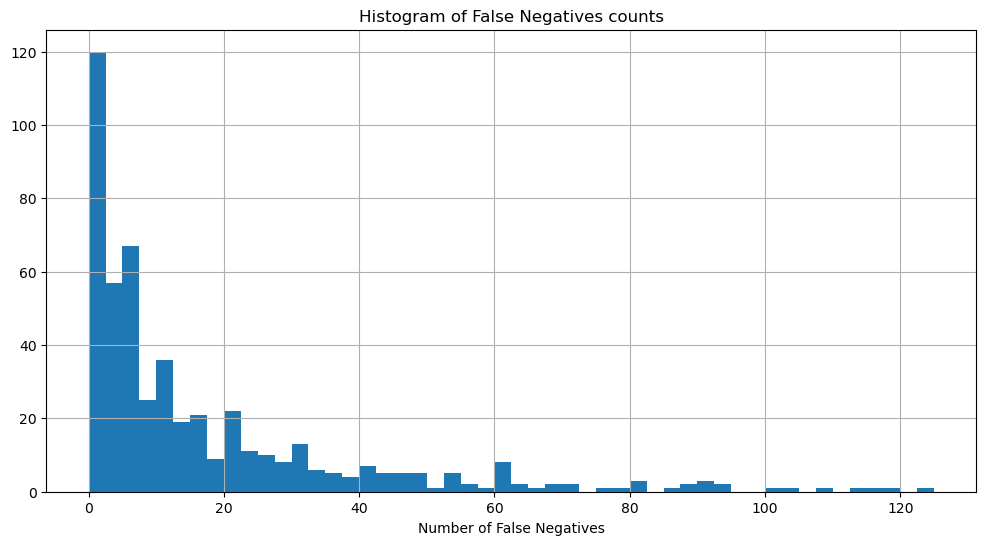

In [32]:
import matplotlib.pyplot as plt

ax = df.FN.hist(bins=50, figsize=(12, 6))
plt.title("Histogram of False Negatives counts")
plt.xlabel("Number of False Negatives")
plt


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

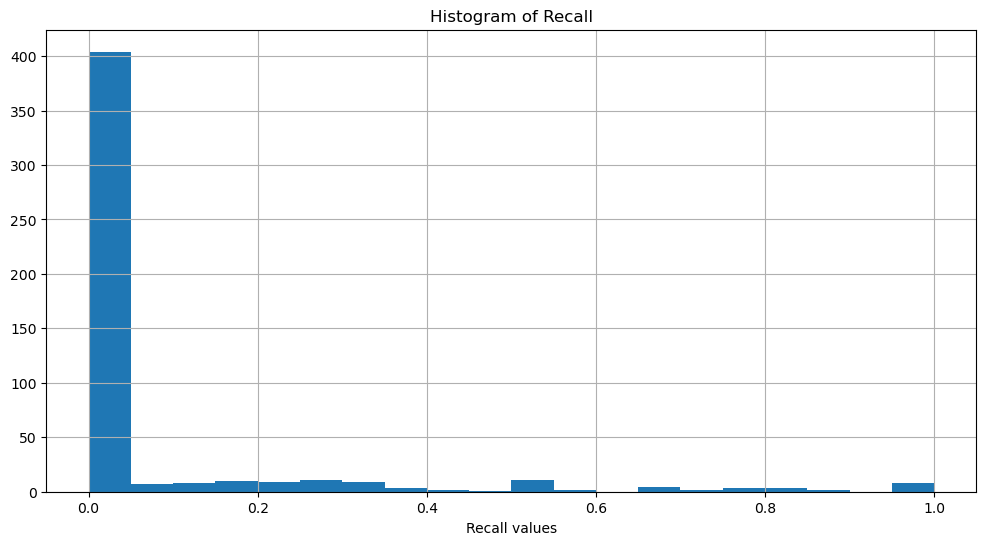

In [35]:

import matplotlib.pyplot as plt

ax = df.recall.hist(bins=20, figsize=(12, 6))
plt.title("Histogram of Recall")
plt.xlabel("Recall values")
plt


### Influence of punctuations in general
Here we outline the influence of punctuations on the evaluated performance. 
A large part of the false negatives in the predictions are punctuations, which points out that we may be misjudging our models and have to filter them out before training. 
As the following table shows, in some languages, punctuation plays a slightly bigger role than in others. 

In [46]:
oida = df.groupby("lang").agg(row_count=('lang', 'size'), value_sum=('FN_punct', 'sum')).reset_index()
oida["sum_rel"] = oida.value_sum / oida.row_count
print(f"Out of {df.FN.sum()} the total False Negatives in the predictions, {oida.value_sum.sum()} of them were punctuations.")
oida.sort_values("sum_rel", ascending=False).rename({"lang": "Language", "row_coutn": "Number of rows", "value_sum":"Number of False Negatives including punctuation", "sum_rel": "Number of False Negatives per row including punctuation"}, axis=1)

Out of 8527 the total False Negatives in the predictions, 2283 of them were punctuations.


,Language,row_count,Number of False Negatives including punctuation,Number of False Negatives per row including punctuation
6,fa,1,12,12.000000
7,fi,44,523,11.886364
0,ar,42,354,8.428571
9,hi,48,364,7.583333
8,fr,49,300,6.122449
12,no,1,5,5.000000
10,it,40,197,4.925000
16,sv,42,155,3.690476
2,de,55,196,3.563636
14,pt,5,13,2.600000
